# Detecting vehicles in images using HOG and SVM

## Steps 
1. Train the classifier from the train images   
    a. Load and visualize train images  
    b. Select and visualize various color spaces  
    c. Select and visualize required train features (HOG and color features)  
    d. Train the classfier  
2. Detect vehicles on the test images  
    a. Do a sliding window search with different window scales tp detect bounding boxes  
    b. Merge the bounding boxes using heat maps and thresholding  
    c. Display bounding boxes on the images  

## Step 1: Creating the model for the classifier


### a. Load and visualize the training images

In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
%matplotlib inline

### Helper functions to visualize and understand the training images

In [2]:
# Define a function to return some characteristics of the dataset 
def data_look(car_list, notcar_list):
    data_dict = {}
    # Define a key in data_dict "n_cars" and store the number of car images
    data_dict["n_cars"] = len(car_list)
    # Define a key "n_notcars" and store the number of notcar images
    data_dict["n_notcars"] = len(notcar_list)
    # Read in a test image, either car or notcar
    car_img = mpimg.imread(car_list[0])
    # Define a key "image_shape" and store the test image shape 3-tuple
    data_dict["image_shape"] = car_img.shape
    # Define a key "data_type" and store the data type of the test image.
    data_dict["data_type"] = car_img.dtype
    # Return data_dict
    return data_dict

In [3]:
def visualize_images(input_images, num_cols, figure_name, cmap = None):
    "Shows input images by stacking them in num_cols columns"
    fig, axes = plt.subplots((int)((len(input_images) + 1) /num_cols), num_cols, figsize=(24, 20))

    fig = plt.gcf()
    fig.canvas.set_window_title(figure_name)
    
    print(figure_name)
    
    for ax, image in zip(axes.flat, input_images):
        if(cmap == "gray" or cmap == 'hot'):
            ax.imshow(image, cmap=cmap)
        elif(image.shape[2]==1):
            ax.imshow(image[:,:,0], cmap = cmap)
        else:
            ax.imshow(image, cmap=cmap)

    plt.show()

### Load images from the disk
Images are in data folder

In [4]:
import glob

#Read cars and not-cars images

#Data folders
vehicles_dir =     '../data/vehicles/'
non_vehicles_dir = '../data/non-vehicles/'

# images are divided up into vehicles and non-vehicles
cars = []
notcars = []

# Read vehicle images
images = glob.iglob(vehicles_dir + '/**/*.png', recursive=True)

for image in images:
        cars.append(image)
        
# Read non-vehicle images
images = glob.iglob(non_vehicles_dir + '/**/*.png', recursive=True)

for image in images:
        notcars.append(image)

print(cars[0])
data_info = data_look(cars, notcars)

print('Your function returned a count of', 
      data_info["n_cars"], ' cars and', 
      data_info["n_notcars"], ' non-cars')
print('of size: ',data_info["image_shape"], ' and data type:', 
      data_info["data_type"])

../data/vehicles\GTI_Far\image0000.png
Your function returned a count of 8792  cars and 8968  non-cars
of size:  (64, 64, 3)  and data type: float32


### Visualize sample images for car and not car types

C:\Users\mahmo\AppData\Local\Temp\ipykernel_21428\4100679351.py:6: MatplotlibDeprecationWarning: 
The set_window_title function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use `.FigureManagerBase.set_window_title` or GUI-specific methods instead.
  fig.canvas.set_window_title(figure_name)


Example Car images


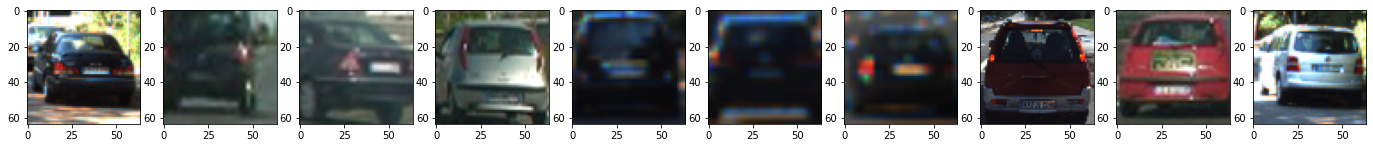

Example not-car images


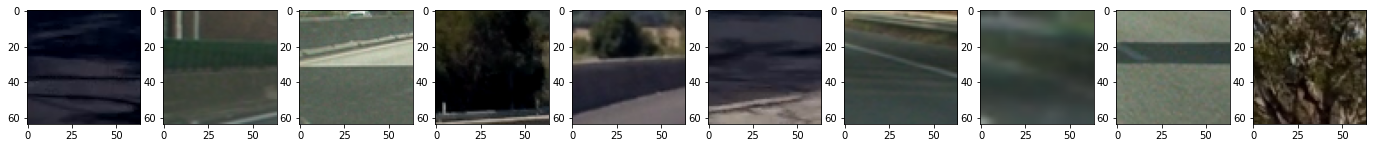

In [5]:
#Visualize some input images
import random

num_images = 10

# Just for fun choose random car / not-car indices and plot example images   
cars_samples = random.sample(list(cars), num_images)
notcar_samples = random.sample(list(notcars), num_images)
    
# Read in car / not-car images
car_images = []
notcar_images = []
for sample in cars_samples:
    car_images.append(mpimg.imread(sample))
    
for sample in notcar_samples:
    notcar_images.append(mpimg.imread(sample))

visualize_images(car_images, num_images, "Example Car images")
visualize_images(notcar_images, num_images, "Example not-car images")

In [6]:
#Helper functions for transforming the images to generate more images

import cv2 
import random

def translate_image(image, pos_range=2):
    """Perturbs the image by translating the image by - pos_range to + pos_range pixels"""
    rows, cols = image.shape[:2] 
    pos_x = pos_range * np.random.uniform() - pos_range/2
    pos_y = pos_range * np.random.uniform() - pos_range/2
    pos_M = np.float32([[1, 0, pos_x],[0, 1, pos_y]])

    return cv2.warpAffine(image, pos_M, (cols,rows))

def scale_image(image, scale = [1.0, 1.1, 1.2]):
    """Perturbs the image by the scale randomly selected from the 'scale' array"""
    scale_M = random.sample(scale, 1)[0]
    image = cv2.resize(image, None, fx = scale_M, fy = scale_M, interpolation = cv2.INTER_AREA)
    return image[0:64, 0:64, :]

def rotate_image(image, rot_range = 2):
    """Perturbs the image by rotation it by an angle randomly selected from rot_rangle"""
    rows, cols = image.shape[:2] 
    rot = np.random.uniform(rot_range)- rot_range/2
    rot_M = cv2.getRotationMatrix2D((cols/2, rows/2), rot, 1)
    
    return cv2.warpAffine(image, rot_M, (cols,rows))

def affine_image(image, affine_range = 2):
    #Affine Transform
    rows, cols = image.shape[:2] 
    pts1 = np.float32([[5, 5],[10, 5],[5, 10]])

    pt1 = 5 + affine_range * np.random.uniform() - affine_range/2
    pt2 = 10 + affine_range * np.random.uniform() - affine_range/2

    pts2 = np.float32([[pt1, 5],[pt2, pt1],[5, pt2]])

    affine_M = cv2.getAffineTransform(pts1, pts2)
    return cv2.warpAffine(image, affine_M, (cols,rows))

def transform_image(image, pos_range = 2, rot_range = 2, scale = [1, 1.1], affine_range = 2):    
    image = translate_image(image, pos_range=5) 
    image = rotate_image(image, rot_range = 5)
    image = scale_image(image, scale = [1.2, 1.4, 1.0])
    is_blurred = random.sample([0, 1], 1)
    if is_blurred[0]:
        image = cv2.GaussianBlur(image,(3,3),0)

    return image

### b. Select and visualize various color spaces

In [7]:
def convert_color(img, conv='RGB2YCrCb'):
    """
    Convert the image from one color space to the other
    """
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    if conv == 'RGB2HLS':
        return cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    if conv == 'RGB2HSV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    if conv == 'Gray':
        return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    if conv == 'RGB2YUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YUV)

In [8]:
from mpl_toolkits.mplot3d import Axes3D

def plot3d(pixels, colors_rgb,
        axis_labels=list("RGB"), axis_limits=((0, 255), (0, 255), (0, 255))):
    """Plot pixels in 3D."""

    # Create figure and 3D axes
    fig = plt.figure(figsize=(6, 6))
    ax = Axes3D(fig)

    # Set axis limits
    ax.set_xlim(*axis_limits[0])
    ax.set_ylim(*axis_limits[1])
    ax.set_zlim(*axis_limits[2])

    # Set axis labels and sizes
    ax.tick_params(axis='both', which='major', labelsize=14, pad=8)
    ax.set_xlabel(axis_labels[0], fontsize=16, labelpad=16)
    ax.set_ylabel(axis_labels[1], fontsize=16, labelpad=16)
    ax.set_zlabel(axis_labels[2], fontsize=16, labelpad=16)

    # Plot pixel values with colors given in colors_rgb
    ax.scatter(
        pixels[:, :, 0].ravel(),
        pixels[:, :, 1].ravel(),
        pixels[:, :, 2].ravel(),
        c=colors_rgb.reshape((-1, 3)), edgecolors='none')

    return ax  # return Axes3D object for further manipulation

### Plot the color spaces in 3d 

C:\Users\mahmo\AppData\Local\Temp\ipykernel_21428\2502647715.py:9: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


<Axes3D:xlabel='Y', ylabel='U'>

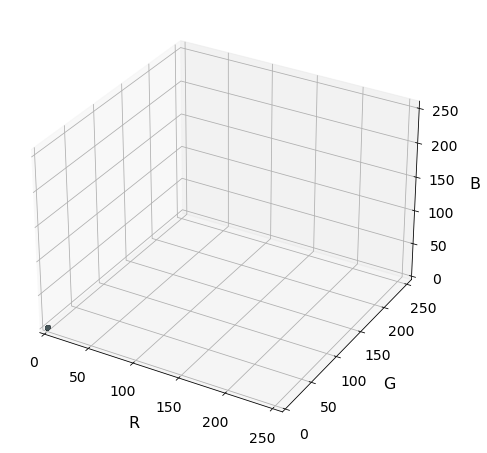

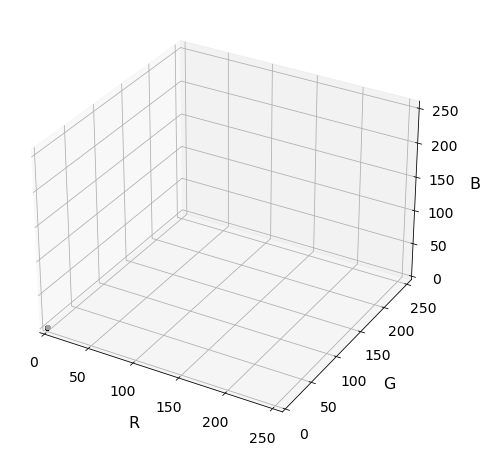

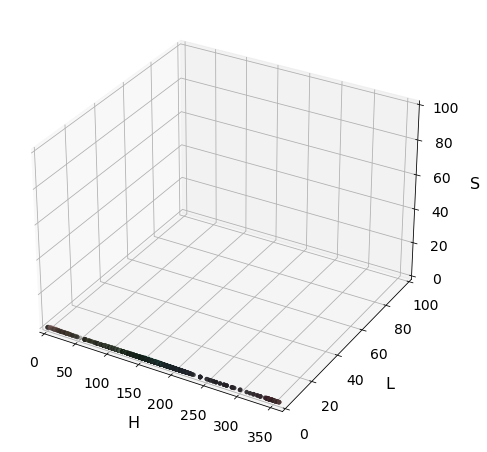

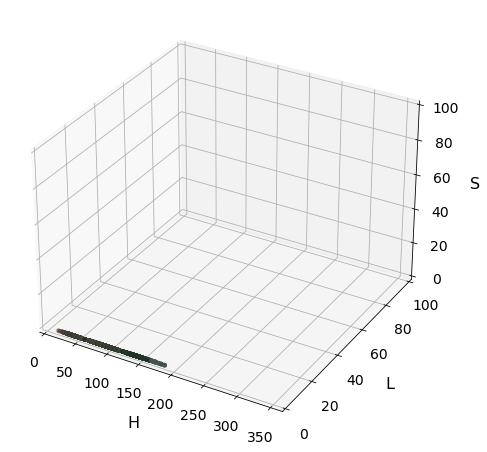

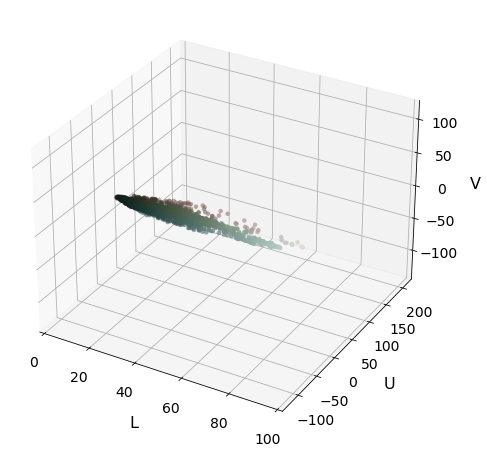

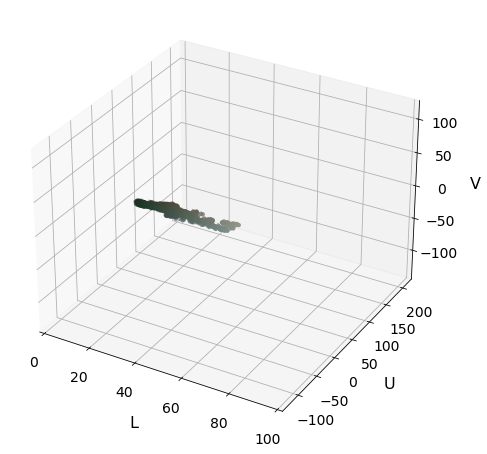

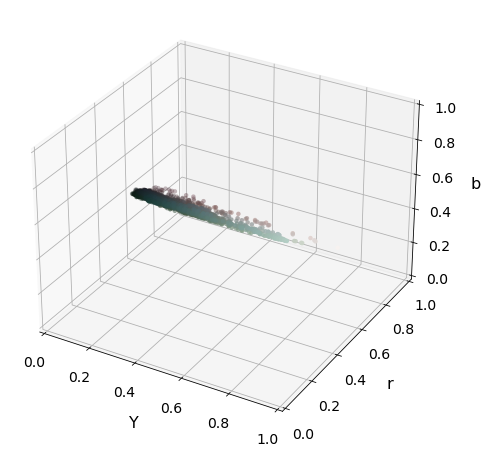

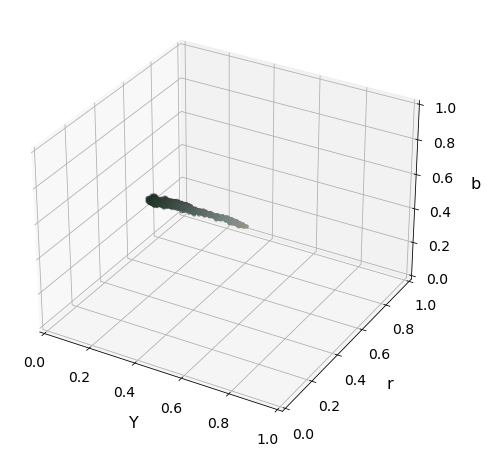

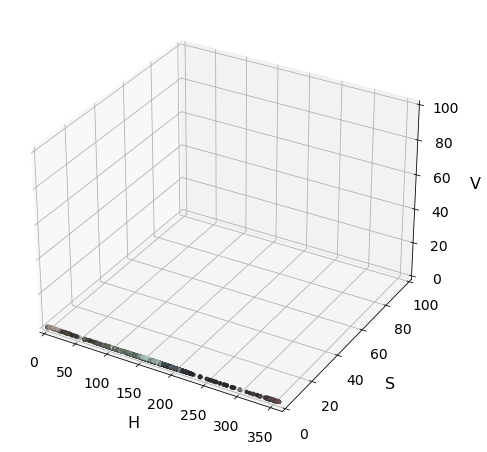

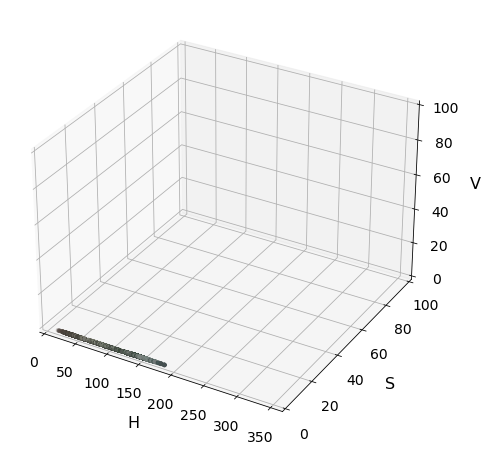

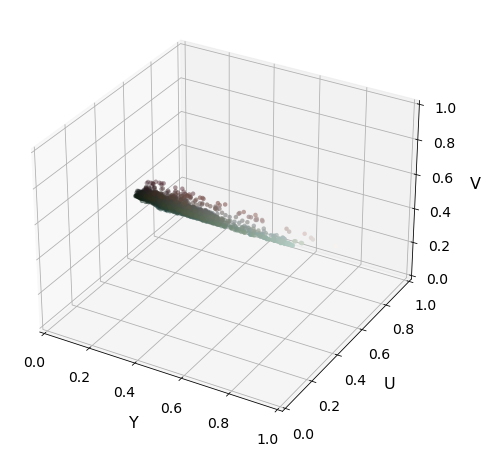

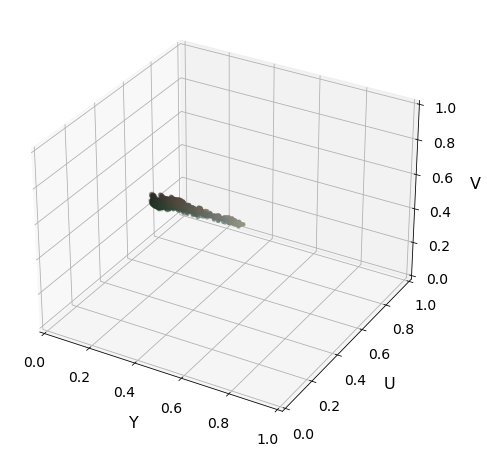

In [9]:
plot3d(car_images[1], car_images[2], axis_labels=list("RGB"))
plot3d(notcar_images[3], notcar_images[3], axis_labels=list("RGB"))

plot3d(convert_color(car_images[1], 'RGB2HLS'), car_images[1], axis_labels=list("HLS"), axis_limits=((0, 360), (0, 100), (0, 100)))
plot3d(convert_color(notcar_images[1], 'RGB2HLS'), notcar_images[1], axis_labels=list("HLS"), axis_limits=((0, 360), (0, 100), (0, 100)))

plot3d(convert_color(car_images[1], 'RGB2LUV'), car_images[1], axis_labels=list("LUV"), axis_limits=((0, 100), (-134,220), (-140,122)))
plot3d(convert_color(notcar_images[1], 'RGB2LUV'), notcar_images[1], axis_labels=list("LUV"), axis_limits=((0, 100), (-134,220), (-140,122)))

plot3d(convert_color(car_images[1], 'RGB2YCrCb'), car_images[1], axis_labels=list("Yrb"), axis_limits=((0, 1), (0, 1), (0, 1)))
plot3d(convert_color(notcar_images[1], 'RGB2YCrCb'), notcar_images[1], axis_labels=list("Yrb"), axis_limits=((0, 1), (0, 1), (0, 1)))

plot3d(convert_color(car_images[1], 'RGB2HSV'), car_images[1], axis_labels=list("HSV"), axis_limits=((0, 360), (0, 100), (0, 100)))
plot3d(convert_color(notcar_images[1], 'RGB2HSV'), notcar_images[1], axis_labels=list("HSV"), axis_limits=((0, 360), (0, 100), (0, 100)))

plot3d(convert_color(car_images[1], 'RGB2YUV'), car_images[1], axis_labels=list("YUV"), axis_limits=((0, 1), (0, 1), (0, 1)))
plot3d(convert_color(notcar_images[1], 'RGB2YUV'), notcar_images[1], axis_labels=list("YUV"), axis_limits=((0, 1), (0, 1), (0, 1)))

#### YUV, YCrCb color spaces are very similar and it seems like from the 3 plots about that they gives the most distinguishable features

Text(0.5, 1.0, 'YUV')

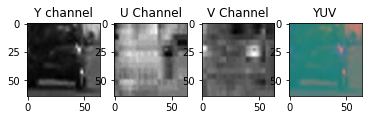

In [10]:
# # Plot the examples
fig = plt.figure()
plt.subplot(141)
yuv_image = convert_color(car_images[1], 'RGB2YUV')
plt.imshow(yuv_image[:,:,0], cmap ="gray")
plt.title('Y channel')
plt.subplot(142)
plt.imshow(yuv_image[:,:,1], cmap ="gray")
plt.title('U Channel')
plt.subplot(143)
plt.imshow(yuv_image[:,:,2], cmap ="gray")
plt.title('V Channel')
plt.subplot(144)
plt.imshow(yuv_image)
plt.title('YUV')

### c. Select and visualize required train features (HOG and color features)

In [11]:
from skimage.feature import hog

def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    """
    Return the hog features of the given input image
    Call with two outputs if vis==True"""
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                                  visualize=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                       visualize=vis, feature_vector=feature_vec)
        return features

Text(0.5, 1.0, 'not car HOG Visualization')

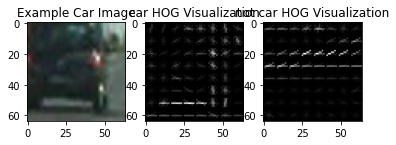

In [12]:
orient = 9
pix_per_cell = 8
cell_per_block = 2

car_features, hog_image = get_hog_features(cv2.cvtColor(car_images[1], cv2.COLOR_RGB2GRAY), orient, pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=True)

notcar_features, notcar_hog_image = get_hog_features(cv2.cvtColor(notcar_images[2], cv2.COLOR_RGB2GRAY), orient, pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=True)

# Plot the examples
fig = plt.figure()
plt.subplot(131)
plt.imshow(car_images[1])
plt.title('Example Car Image')
plt.subplot(132)
plt.imshow(hog_image, cmap='gray')
plt.title('car HOG Visualization')
plt.subplot(133)
plt.imshow(notcar_hog_image, cmap='gray')
plt.title('not car HOG Visualization')

In [13]:
def bin_spatial(img, size=(16, 16)):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))

In [14]:
# Define a function to compute color histogram features 
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

In [15]:
# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, cspace='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel='ALL',
                        spatial_feat=False, hist_feat=False, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        image = (image * 255).astype(np.uint8)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)   

            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

### d. Train the classifier on the features

In [16]:
import time
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler

colorspace = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_size=(32, 32)
hist_bins=32

t=time.time()

car_features = extract_features(cars, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, hist_bins=hist_bins)
notcar_features = extract_features(notcars, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, hist_bins=hist_bins)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract HOG features...')
# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64) 
print(X.shape)
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

print(len(y))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.15, random_state=rand_state)

#X_train, X_test = shuffle(X_train, y_train, random_state=rand_state)
# # Compute a PCA  on the features 
# n_components = 4932

# print("Extracting the top %d features from %d total features"
#       % (n_components, X_train.shape[1]))

# pca = PCA(n_components=n_components, svd_solver='randomized',
#           whiten=True).fit(X_train)

# X_train_pca = pca.transform(X_train)
print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))

# Use a linear SVC X_scaler
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')

116.85 Seconds to extract HOG features...
(17760, 5292)
17760
Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 5292
15.5 Seconds to train SVC...


C:\Users\mahmo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [17]:
# print(np.arange(4932).shape)
# test = X_scaler.transform(np.zeros(4932, 4932))
# print(svc.predict(np.arange(5292).reshape(-1,1)))

In [18]:
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

Test Accuracy of SVC =  0.9887
My SVC predicts:  [0. 1. 0. 0. 0. 0. 1. 1. 1. 0.]
For these 10 labels:  [0. 1. 1. 0. 0. 0. 1. 1. 1. 0.]
0.00482 Seconds to predict 10 labels with SVC


#### Save the training model 

In [19]:
import pickle

#Pickle the data as it takes a lot of time to generate it

import os
data_file = '../results/model/svc_pickle.p'

if not os.path.isfile(data_file):
    with open(data_file, 'wb') as pfile:
        pickle.dump(
            {
                'svc': svc,
                'scaler': X_scaler,
                'orient': orient,
                'pix_per_cell': pix_per_cell,
                'cell_per_block': cell_per_block,
                'spatial_size': spatial_size,
                'hist_bins': hist_bins
                
            },
            pfile, pickle.HIGHEST_PROTOCOL)

print('Data saved in pickle file')

Data saved in pickle file


## Step 2: Detect vehicles on the test images


#### Load the training model

In [20]:
# dist_pickle = pickle.load( open("../results/model/svc_pickle.p", "rb" ) )
# print(dist_pickle)
# svc = dist_pickle["svc"]
# X_scaler = dist_pickle["scaler"]
# orient = dist_pickle["orient"]
# pix_per_cell = dist_pickle["pix_per_cell"]
# cell_per_block = dist_pickle["cell_per_block"]
# spatial_size = dist_pickle["spatial_size"]
# hist_bins = dist_pickle["hist_bins"]

#### Load the test images

In [21]:
#Read cars and not-cars images

#Data folders
test_images_dir = '../data/test_images/'

# images are divided up into vehicles and non-vehicles
test_images = []

images = glob.glob(test_images_dir + '*.jpg')

for image in images:
        test_images.append(mpimg.imread(image))

### Steps for running the models of the test images
a. Do a sliding window search with different window scales tp detect bounding boxes  
b. Merge the bounding boxes using heat maps and thresholding  
c. Display bounding boxes on the images  

In [22]:

# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, vis_bboxes = False):
    
    draw_img = np.copy(img)
    xstart = int(img.shape[1]/5)
    xstop = img.shape[1]
    img_tosearch = img[ystart:ystop, xstart:xstop,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YUV')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))

    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step

    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    rectangles = []

    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3)).reshape(1, -1)
#             hog_features = np.hstack((hog_feat1))
            
            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
#             subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
 
             # Get color features
#             spatial_features = bin_spatial(subimg, size=spatial_size)
#             hist_features = color_hist(subimg, nbins=hist_bins)
            # Scale features and make a prediction
#             stacked = np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1)
            test_features = X_scaler.transform(hog_features)   
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1 or vis_bboxes == True:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                rectangles.append(((xbox_left+xstart, ytop_draw+ystart),(xbox_left+win_draw+xstart,ytop_draw+win_draw+ystart)))
                              
    return rectangles

In [23]:
def get_rectangles(image, scales = [1, 1.5, 2, 2.5, 3], 
                   ystarts = [400, 400, 450, 450, 460], 
                   ystops = [528, 550, 620, 650, 700]):
    out_rectangles = []
    for scale, ystart, ystop in zip(scales, ystarts, ystops):
        rectangles = find_cars(image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
        if len(rectangles) > 0:
            out_rectangles.append(rectangles)
    out_rectangles = [item for sublist in out_rectangles for item in sublist] 
    return out_rectangles

In [24]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap

In [25]:
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

In [26]:
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    img_copy = np.copy(img)
    result_rectangles = []
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        area = (bbox[1][1] - bbox[0][1]) * (bbox[1][0] - bbox[0][0])
        if area > 40 * 40:
            result_rectangles.append(bbox)
            # Draw the box on the image
            cv2.rectangle(img_copy, bbox[0], bbox[1], (0,255,0), 6)
    # Return the image
    return result_rectangles, img_copy

In [27]:
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    random_color = False
    # Iterate through the bounding boxes
    for bbox in bboxes:
        if color == 'random' or random_color:
            color = (np.random.randint(0,255), np.random.randint(0,255), np.random.randint(0,255))
            random_color = True
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

In [28]:
def visualize_bboxes(image, scales = [1, 1.5, 2, 2.5, 3], 
                   ystarts = [400, 400, 450, 450, 460], 
                   ystops = [528, 550, 620, 650, 700]):
    out_rectangles = []
    for scale, ystart, ystop in zip(scales, ystarts, ystops):
        rectangles = find_cars(image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, vis_bboxes = True)
        if len(rectangles) > 0:
            out_rectangles.append(rectangles)
    out_rectangles = [item for sublist in out_rectangles for item in sublist] 

    plt.figure(figsize=(20,10))
    plt.imshow(draw_boxes(image, out_rectangles, color='random', thick=3))

C:\Users\mahmo\AppData\Local\Temp\ipykernel_21428\1160554645.py:63: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  xbox_left = np.int(xleft*scale)
C:\Users\mahmo\AppData\Local\Temp\ipykernel_21428\1160554645.py:64: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note l

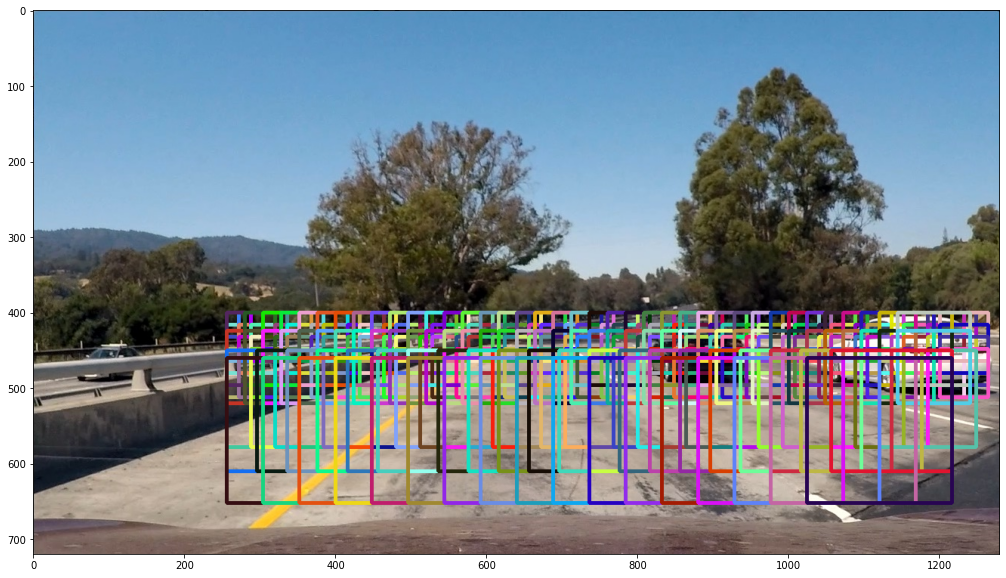

In [29]:
visualize_bboxes(test_images[0])

In [30]:
from scipy.ndimage.measurements import label

result_images = []
result_boxes = []
heatmap_images = []
result_img_all_boxes = []
for test_image in test_images:
    rectangles = get_rectangles(test_image)
    result_img_all_boxes.append(draw_boxes(test_image, rectangles, color='random', thick=3))
    heatmap_image = np.zeros_like(test_image[:, :, 0])
    heatmap_image = add_heat(heatmap_image, rectangles)
    heatmap_images.append(heatmap_image)
    heatmap_image = apply_threshold(heatmap_image, 2)
    labels = label(heatmap_image)
    rectangles, result_image = draw_labeled_bboxes(test_image, labels)
    result_boxes.append(rectangles)
    result_images.append(result_image)

C:\Users\mahmo\AppData\Local\Temp\ipykernel_21428\4040116753.py:1: DeprecationWarning: Please use `label` from the `scipy.ndimage` namespace, the `scipy.ndimage.measurements` namespace is deprecated.
  from scipy.ndimage.measurements import label
C:\Users\mahmo\AppData\Local\Temp\ipykernel_21428\1160554645.py:63: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  xbox_left = np.int(xleft*scale)
C:\Users\mahmo\AppData\Local\Temp\ipykernel_21428\1160554645.py:64: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this w

C:\Users\mahmo\AppData\Local\Temp\ipykernel_21428\4100679351.py:6: MatplotlibDeprecationWarning: 
The set_window_title function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use `.FigureManagerBase.set_window_title` or GUI-specific methods instead.
  fig.canvas.set_window_title(figure_name)


test


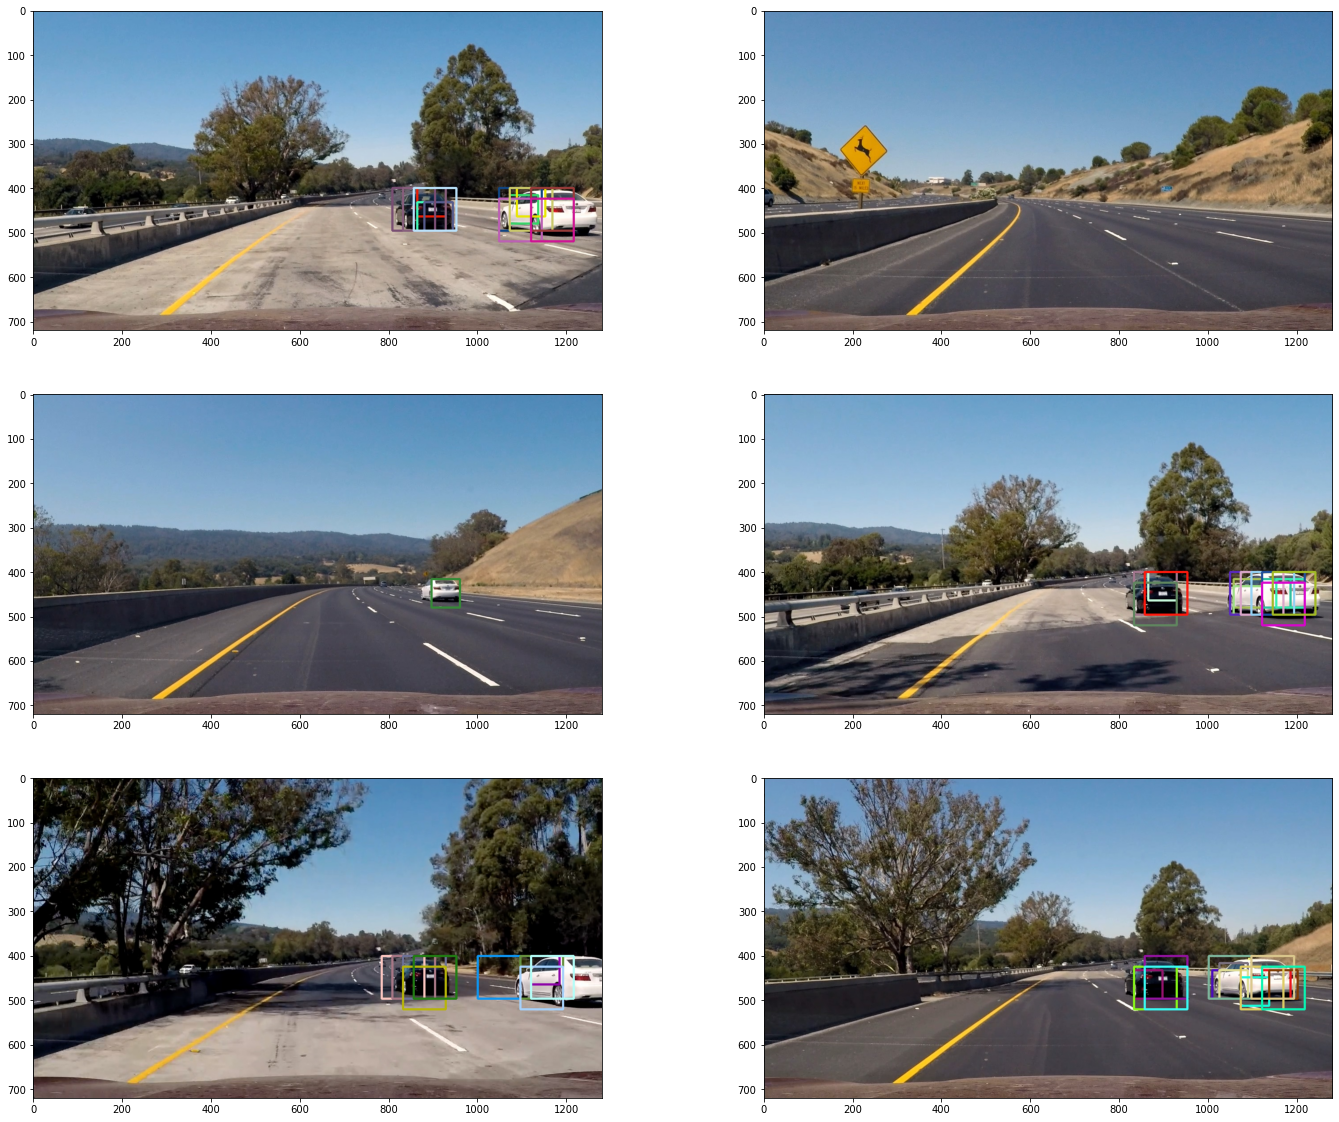

In [31]:
visualize_images(result_img_all_boxes, 2, "test")

C:\Users\mahmo\AppData\Local\Temp\ipykernel_21428\4100679351.py:6: MatplotlibDeprecationWarning: 
The set_window_title function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use `.FigureManagerBase.set_window_title` or GUI-specific methods instead.
  fig.canvas.set_window_title(figure_name)


test


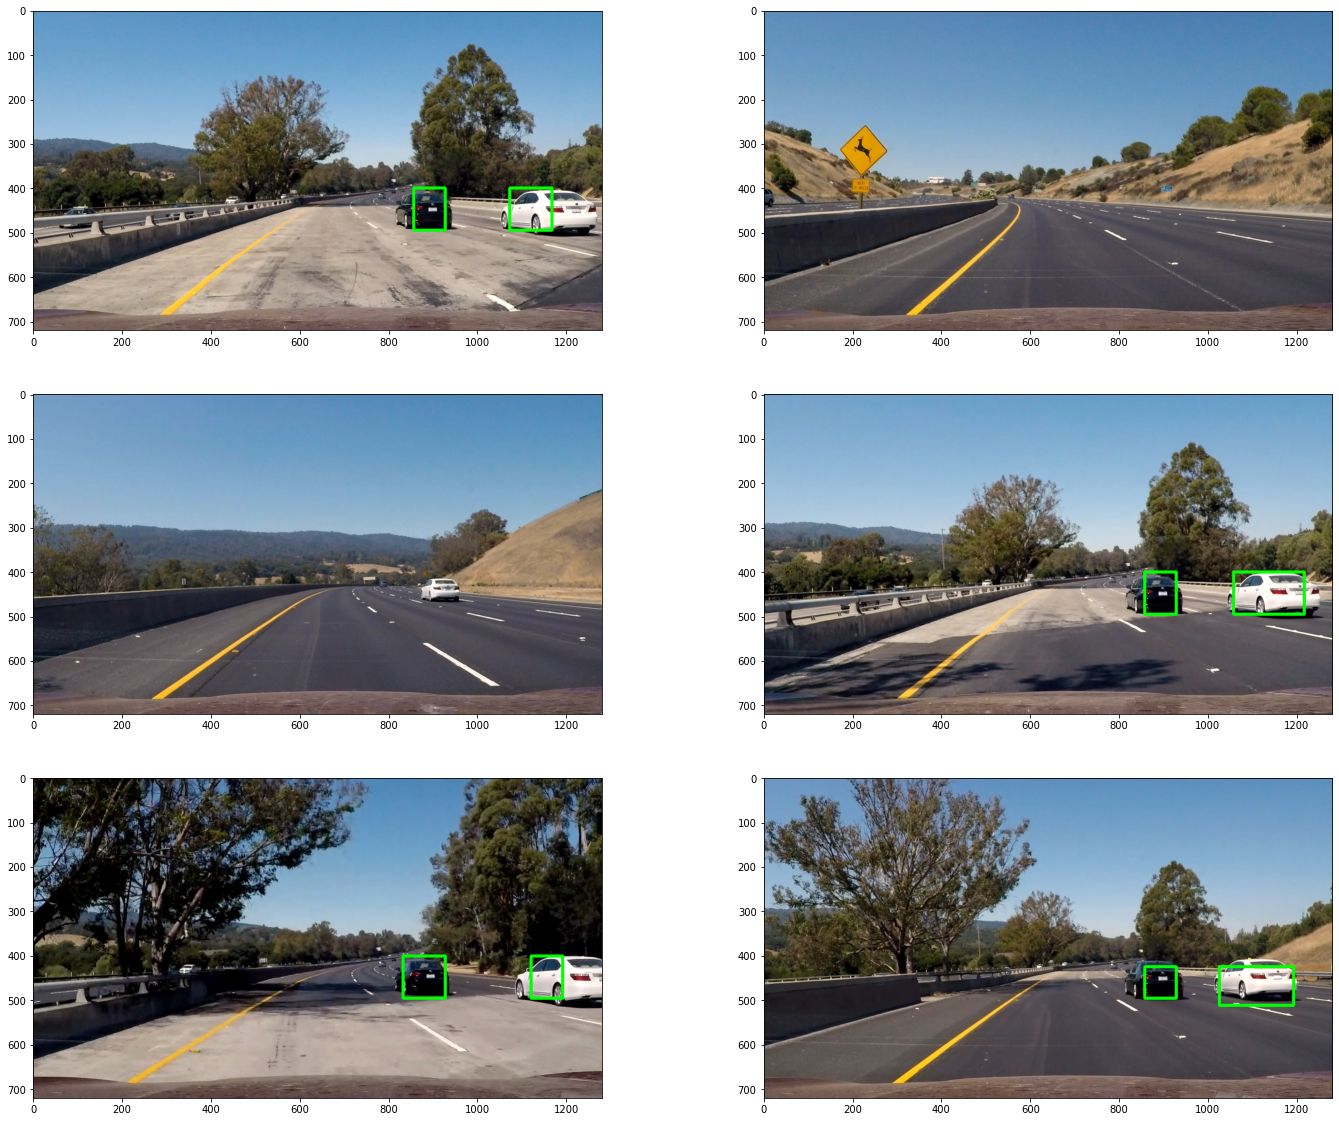

In [32]:
visualize_images(result_images, 2, "test")

C:\Users\mahmo\AppData\Local\Temp\ipykernel_21428\4100679351.py:6: MatplotlibDeprecationWarning: 
The set_window_title function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use `.FigureManagerBase.set_window_title` or GUI-specific methods instead.
  fig.canvas.set_window_title(figure_name)


Heatmap


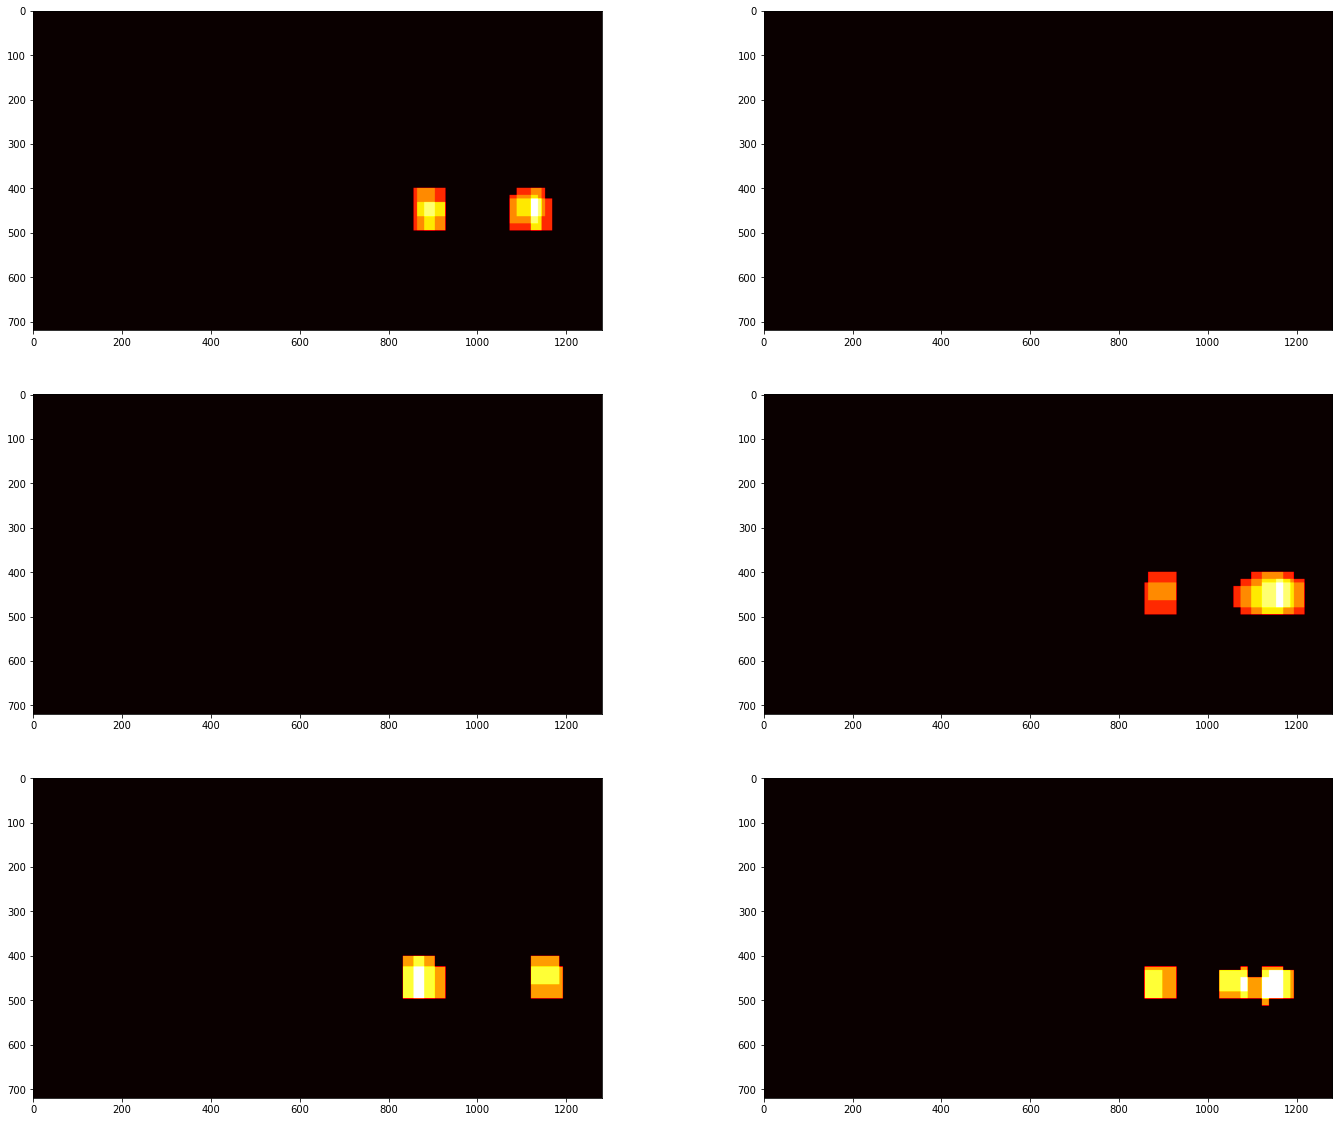

In [33]:
visualize_images(heatmap_images, 2, "Heatmap", cmap="hot")

## Video Processing

In [34]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import queue

In [35]:
class DetectionInfo():
    def __init__(self):
        self.max_size = 10
        self.old_bboxes = queue.Queue(self.max_size) 
        self.heatmap = np.zeros_like(test_images[0][:, :, 0])
        
    def get_heatmap(self):
        self.heatmap = np.zeros_like(test_images[0][:, :, 0])
        if self.old_bboxes.qsize() == self.max_size:
            for bboxes in list(self.old_bboxes.queue):
                self.heatmap = add_heat(self.heatmap, bboxes)
                #self.heatmap = apply_threshold(self.heatmap, 2)
            self.heatmap = apply_threshold(self.heatmap, 20)
        return self.heatmap
    
    def get_labels(self):
        return label(self.get_heatmap())
        
    def add_bboxes(self, bboxes):
        if len(bboxes) < 1:
            return
        if self.old_bboxes.qsize() == self.max_size:
            self.old_bboxes.get()
        self.old_bboxes.put(bboxes)
            

In [36]:
def find_vehicles(image):
    bboxes = get_rectangles(image) 
    detection_info.add_bboxes(bboxes)
    labels = detection_info.get_labels()
    if len(labels) == 0:
        result_image = image
    else:
        bboxes, result_image = draw_labeled_bboxes(image,labels)

    return result_image

In [38]:
detection_info = DetectionInfo()
detection_info.old_heatmap = np.zeros_like(test_images[0][:, :, 0])
project_video_path = '../data/test_videos/test_video.mp4'
project_video_output = '../results/output_videos/test_video.mp4'

project_video = VideoFileClip(project_video_path)
white_clip = project_video.fl_image(find_vehicles) #NOTE: this function expects color images!!
%time white_clip.write_videofile(project_video_output, audio=False)

t:   0%|          | 2/1260 [00:57<06:29,  3.23it/s, now=None]

Moviepy - Building video ../MH/output_videos/test_video.mp4.
Moviepy - Writing video ../MH/output_videos/test_video.mp4



OSError: [Errno 22] Invalid argument

MoviePy error: FFMPEG encountered the following error while writing file ../MH/output_videos/test_video.mp4:

 b'../MH/output_videos/test_video.mp4: No such file or directory\r\n'

In [ ]:
detection_info = DetectionInfo()
detection_info.old_heatmap = np.zeros_like(test_images[0][:, :, 0])
project_video_path = '../data/test_videos/project_video.mp4'
project_video_output = '../results/output_videos/project_video.mp4'

project_video = VideoFileClip(project_video_path)
white_clip = project_video.fl_image(find_vehicles) #NOTE: this function expects color images!!
%time white_clip.write_videofile(project_video_output, audio=False)

[MoviePy] >>>> Building video ../results/output_videos/project_video.mp4
[MoviePy] Writing video ../results/output_videos/project_video.mp4


100%|█████████▉| 1260/1261 [07:11<00:00,  2.97it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ../results/output_videos/project_video.mp4 

CPU times: user 19min 19s, sys: 3.07 s, total: 19min 22s
Wall time: 7min 12s
